# Disaster Tweet Classification with RNN (LSTM/GRU)

This project is **Natural Language Processing with Disaster Tweets** using recurrent neural networks. The objective is to predict whether a tweet refers to an actual disaster. The official training set contains **7613** tweets, each with an identifier (`id`), optional `keyword` and `location`, the `text` of the tweet, and a binary `target` indicating whether it describes a disaster (1) or not (0). The test set contains **3263** tweets without `target` labels.  The dataset is drawn from Kaggle’s *NLP with Disaster Tweets* competition.

Kaggle reference (APA format):

> Kaggle. (2020). *Natural Language Processing with Disaster Tweets* [Data set]. Kaggle. https://www.kaggle.com/competitions/nlp-getting-started/data


In [19]:
import os
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

## Data Summary
- In the Kaggle dataset, there are **10,876** tweets with five columns: `id`, `keyword`, `location`, `text`, and `target`.
- The dataset is already split into a train and test set. The training data has 7,613 rows and the testing data has 3,263 rows.
- The `target` column is `1` for tweets describing disasters and `0` for non-disaster tweets.
- The dataset includes a balanced mix of disaster and non‑disaster tweets (3,271 disaster tweets vs 4,342 non-disaster tweets).
- Missing values occur in the `keyword` and `location` columns.

In [20]:
# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Concatenate to create full dataset
df = pd.concat([train_df, test_df])
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [21]:
# Basic information about the dataset
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print('\nData types:')
print(df.dtypes)

Number of rows: 10876
Number of columns: 5

Data types:
id            int64
keyword      object
location     object
text         object
target      float64
dtype: object


## Exploratory Data Analysis (EDA)

I first explore the training dataset to understand its size, structure, and class distribution. Understanding class imbalance is important when evaluating model performance. I also check for missing values in the `keyword` and `location` fields and examine tweet lengths.

#### Target Class Distribution

Target class distribution (0=non-disaster, 1=disaster):
target
0.0    4342
1.0    3271
Name: count, dtype: int64 



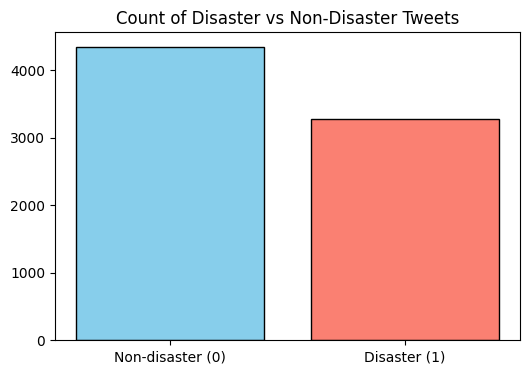

In [22]:
# Target class distribution
print('Target class distribution (0=non-disaster, 1=disaster):')
print(df['target'].value_counts(), '\n')

# Plot distribution
counts = df['target'].value_counts().sort_index()  # ensure order 0 then 1
plt.figure(figsize=(6, 4))
bars = plt.bar(
    ['Non-disaster (0)', 'Disaster (1)'],
    counts.values,
    color=['skyblue', 'salmon'],
    edgecolor='black'
)
plt.title('Count of Disaster vs Non-Disaster Tweets')
plt.xticks(rotation=0)
plt.show()

> The target shows some class imbalance:  
>   - Non-Disaster = 57% of target values
>   - Disaster = 43% of target values

#### MIssing Values

In [23]:
print('Missing values per column:')
print(df.isnull().sum(), '\n')

Missing values per column:
id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64 



> Note: the `target` column has 3263 missing values because `test_df` doesn't include target values.

#### Word Count Distributions

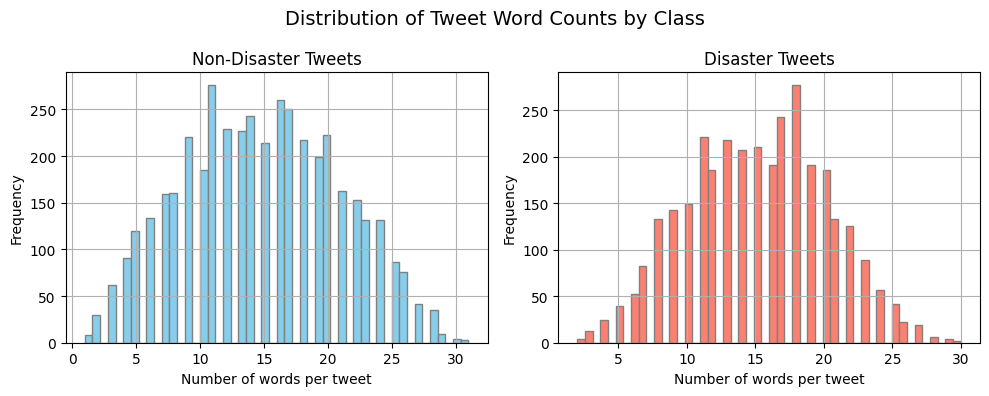

In [24]:
# Add tweet length column
train_df['length'] = train_df['text'].apply(lambda x: len(x.split()))

# Create side-by-side histograms
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
train_df[train_df['target'] == 0]['length'].hist(bins=50, color='skyblue', edgecolor='grey')
plt.title('Non-Disaster Tweets')
plt.xlabel('Number of words per tweet')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
train_df[train_df['target'] == 1]['length'].hist(bins=50, color='salmon', edgecolor='grey')
plt.title('Disaster Tweets')
plt.xlabel('Number of words per tweet')
plt.ylabel('Frequency')

plt.suptitle('Distribution of Tweet Word Counts by Class', fontsize=14)
plt.tight_layout()
plt.show()

> Both the Non-Disaster and Disaster tweets appear to be somewhat normally distributed.

#### Frequent Keywords

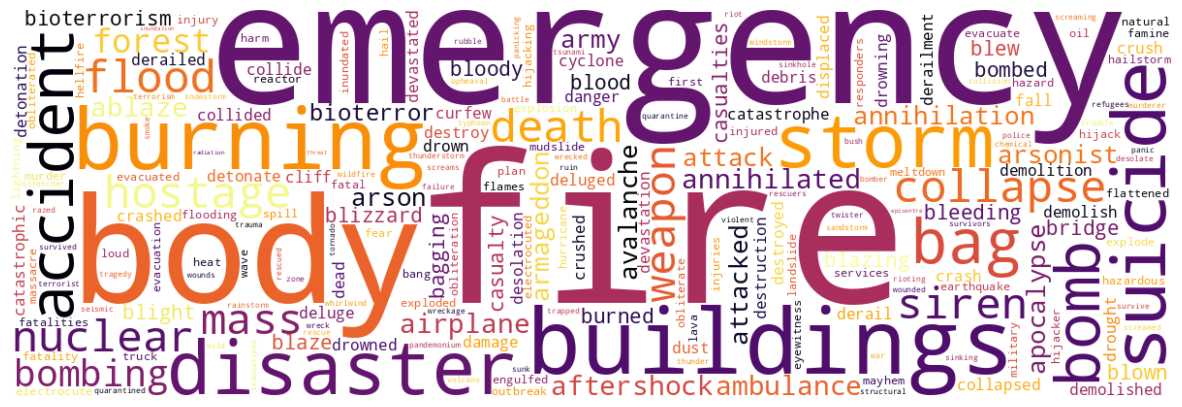

In [25]:
# Replace '%20' with spaces
df['keyword'] = df['keyword'].str.replace('%20', ' ')

# Drop missing keywords and combine into a single string
keywords_text = ' '.join(df['keyword'].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=400,
    background_color='white',
    colormap='inferno',
    max_words=1000,
    collocations=False
).generate(keywords_text)

# Display the word cloud
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## RNN Model Architecture

I'm testing two neural network architectures:

1. **LSTM** model: Embedding → LSTM → Dense
2. **Bidirectional GRU** model: Embedding → Bidirectional(GRU) → Dense

Both models use an Embedding layer to learn word vectors during training. The models are compiled with the binary cross‑entropy loss and evaluated using accuracy and F1‑score. A validation split from the training data is used to monitor performance and prevent overfitting via early stopping.

#### Text Preprocessing

I preprocess the text by cleaning and tokenizing. Using `tf.keras.preprocessing.text.Tokenizer`, I convert each tweet into a sequence of integer indices, keeping only the most frequent words. Sequences are padded to a uniform length using `tf.keras.preprocessing.sequence.pad_sequences`.

In [26]:
# Convert text column
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Tokenization
max_words = 20000  # vocabulary size
max_len = 30       # maximum sequence length

# Fit tokenizer on training text
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

y = train_df['target'].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define model architectures
embedding_dim = 64

# Set random seed
tf.random.set_seed(666)

#### LSTM Model

In [ ]:
# LSTM model
lstm_model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.build((None, max_len))
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 30, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,089 (5.01 MB)

 Trainable params: 1,313,089 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit LSTM model
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
)

# Evaluate on validation set
lstm_val_pred = (lstm_model.predict(X_val) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_val, lstm_val_pred)
lstm_f1 = f1_score(y_val, lstm_val_pred)
print(f'LSTM Validation Accuracy: {lstm_accuracy:.4f}')
print(f'LSTM Validation F1: {lstm_f1:.4f}')

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6131 - loss: 0.6551 - val_accuracy: 0.7741 - val_loss: 0.4921
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8221 - loss: 0.4216 - val_accuracy: 0.7991 - val_loss: 0.4568
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9052 - loss: 0.2702 - val_accuracy: 0.7991 - val_loss: 0.4716
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9384 - loss: 0.1939 - val_accuracy: 0.7873 - val_loss: 0.5827
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM Validation Accuracy: 0.7991
LSTM Validation F1: 0.7650


#### Bidirectional GRU Model


In [34]:
# Bidirectional GRU model
gru_model = Sequential([
    Embedding(max_words, embedding_dim),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.build((None, max_len))
gru_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 30, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,049 (5.07 MB)

 Trainable params: 1,330,049 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit GRU model
gru_history = gru_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
)

# Evaluate GRU
gru_val_pred = (gru_model.predict(X_val) > 0.5).astype(int)
gru_accuracy = accuracy_score(y_val, gru_val_pred)
gru_f1 = f1_score(y_val, gru_val_pred)
print(f'Bidirectional GRU Validation Accuracy: {gru_accuracy:.4f}')
print(f'Bidirectional GRU Validation F1: {gru_f1:.4f}')

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.6028 - loss: 0.6565 - val_accuracy: 0.7853 - val_loss: 0.4695
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.8400 - loss: 0.3791 - val_accuracy: 0.7886 - val_loss: 0.4849
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9094 - loss: 0.2341 - val_accuracy: 0.7958 - val_loss: 0.5472
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Bidirectional GRU Validation Accuracy: 0.7853
Bidirectional GRU Validation F1: 0.7419


#### LSTM Model (Hyperparameter Tuned)


In [ ]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32)))
    model.add(LSTM(
        hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout',min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner for LSTM
lstm_tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Run the search for LSTM
print("Running KerasTuner search for LSTM model...")
lstm_tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Get the best LSTM model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

# Evaluate the best LSTM model
lstm_val_pred = (best_lstm_model.predict(X_val) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_val, lstm_val_pred)
lstm_f1 = f1_score(y_val, lstm_val_pred)
print(f'Best Hyperparameter Tuned LSTM Validation Accuracy: {lstm_accuracy:.4f}')
print(f'Best Hyperparameter Tuned LSTM Validation F1: {lstm_f1:.4f}')

Trial 10 Complete [00h 00m 34s]
val_accuracy: 0.8017071485519409

Best val_accuracy So Far: 0.810899555683136
Total elapsed time: 00h 06m 31s
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Best Hyperparameter Tuned LSTM Validation Accuracy: 0.8109
Best Hyperparameter Tuned LSTM Validation F1: 0.7632


#### Bidirectional GRU Model (Hyperparameter Tuned)

In [ ]:
def build_gru_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, hp.Int('embedding_dim', min_value=32, max_value=128, step=32)))
    model.add(Bidirectional(GRU(
        hp.Int('gru_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1))
    ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner for GRU
gru_tuner = kt.Hyperband(
    build_gru_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='gru_tuning'
)

# Run the search for GRU
print("Running KerasTuner search for Bidirectional GRU model...")
gru_tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Get the best GRU model
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]

# Evaluate the best GRU model
gru_val_pred = (best_gru_model.predict(X_val) > 0.5).astype(int)
gru_accuracy = accuracy_score(y_val, gru_val_pred)
gru_f1 = f1_score(y_val, gru_val_pred)
print(f'Best Hyperparameter Tuned Bidirectional GRU Validation Accuracy: {gru_accuracy:.4f}')
print(f'Best Hyperparameter Tuned Bidirectional GRU Validation F1: {gru_f1:.4f}')

Trial 10 Complete [00h 01m 29s]
val_accuracy: 0.8063033223152161

Best val_accuracy So Far: 0.8082731366157532
Total elapsed time: 00h 12m 38s
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Best Hyperparameter Tuned Bidirectional GRU Validation Accuracy: 0.8083
Best Hyperparameter Tuned Bidirectional GRU Validation F1: 0.7618


## Model Result Summary

| Model                                     | Accuracy | F1-score |
| :---------------------------------------- | :------- | :------- |
| LSTM                                      | 0.7991   | 0.7650   |
| Bidirectional GRU                         | 0.7853   | 0.7419   |
| Best Hyperparameter Tuned LSTM            | 0.8109   | 0.7632   |
| Best Hyperparameter Tuned Bidirectional GRU | 0.8083   | 0.7618   |

The hyperparameter-tuned LSTM model achieved the highest validation accuracy (0.8109), while the initial non-tuned LSTM model had the highest validation F1-score (0.7650). However, the difference in F1-scores between the tuned and non-tuned LSTM models is small (0.7632 vs 0.7650). Overall, hyperparameter tuning improved the accuracy of both models.

In [ ]:
# Define best model
best_model = best_gru_model

# Predict best model
pred_test = (best_model.predict(X_test_seq) > 0.5).astype(int).flatten()

# Create Kaggle submission dataframe
submission = pd.DataFrame({'id': test_df['id'], 'target': pred_test})

# Save to CSV (path can be changed for local use)
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print('Submission file saved to', submission_path)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Submission file saved to submission.csv


Kaggle results:  

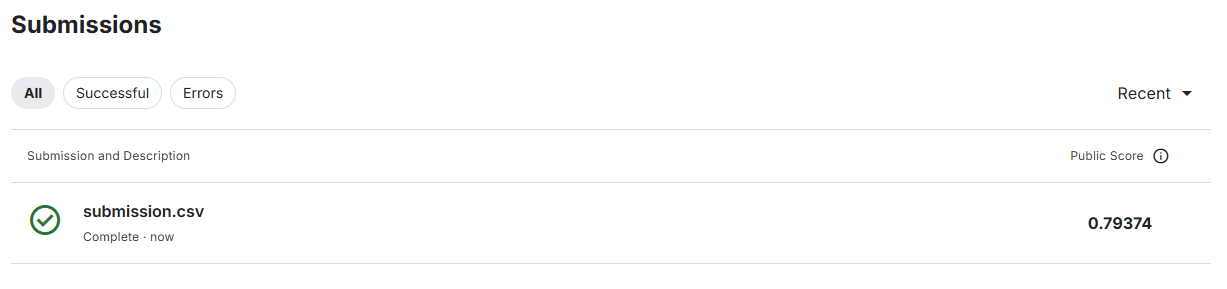

## Conclusion

**Learnings:**  
The hyperparameter-tuned LSTM model showed slightly better performance in both accuracy and F1-score compared to the tuned Bidirectional GRU model. Importantly, tuning with KerasTuner helped find better model configurations, improving performance over the initial models. The dataset has some class imbalance, making the F1-score a key metric for evaluating the model's ability to identify disaster tweets.  

**What helped / did not help:**  
Hyperparameter tuning was clearly beneficial for improving performance. Using the F1-score provided a better evaluation for the imbalanced data. The initial basic LSTM and Bidirectional GRU models had similar performance, and the commented-out keyword grouping was not utilized in the final models, so their impact is unknown.  

**Future Improvements:**  
To further improve the model, consider addressing class imbalance using techniques like oversampling, undersampling, or class weights. Exploring more advanced models such as stacked RNNs or Transformer models like BERT could also be beneficial. Refining text preprocessing and exploring better ways to incorporate keyword and location data through feature engineering are also potential avenues. Finally, conducting a more extensive hyperparameter search, considering ensembling multiple models, and performing error analysis on misclassified tweets can help identify and address weaknesses.
